# GFs for MNIST (Splines-Multiscale)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
import wandb

wandb_logger = wandb.init(project="gf_mnist_ms", entity="ipl_uv")

wandb_logger.config.seed = 123

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [5]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

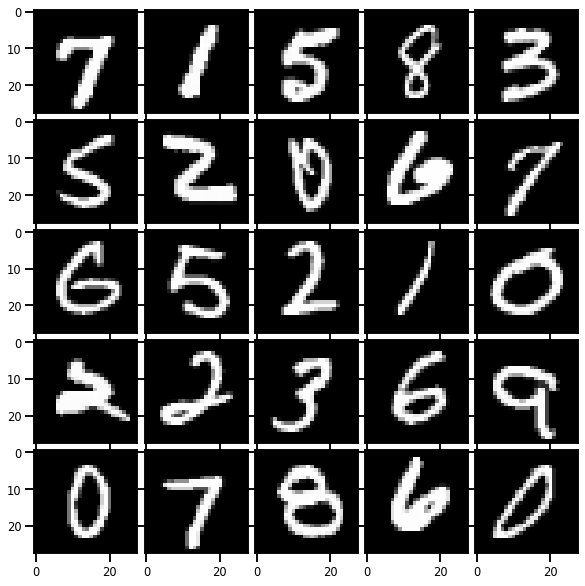

In [6]:
# train/valid dataset loaders
wandb_logger.config.batch_size = 64
n_init_samples = 5_000
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)

# demo batch
demo_batch = next(init_ds)

# plot batch of images
fig, ax = plot_image_grid(demo_batch["image"])

wandb.log({"demo_images": wandb.Image(plt)})

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [7]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch["image"].astype(jnp.float32)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape).astype(jnp.float32)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

#### Demo

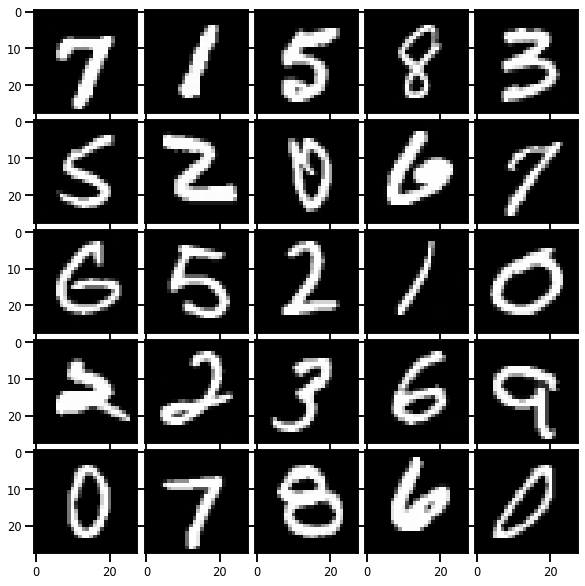

In [8]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
demo_data_prepped = prepare_data(demo_batch, prng_key=prng_key)

# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
fig, ax = plot_image_grid(demo_data_prepped, image_shape)

wandb.log({"demo_images_prepped": wandb.Image(plt)})

## Model

### Initialize Data

In [45]:
# initialization data
n_init_samples = 10_000
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
init_ds = next(init_ds)
init_data_prepped = prepare_data(init_ds, prng_key=prng_key)
X_init = np.array(init_data_prepped)

In [54]:
# parameters
n_bins = 16
range_min = -12
range_max = 12
boundary_slopes = "unconstrained"
identity_init = False

n_reflections = 10
init_rotation = "random"

# nn params
n_blocks = 4
image_shape = ImageShape(C=1, H=28, W=28)
filters = [(2, 2), (4, 4), (7, 7,), (14, 14)]

In [55]:
from rbig_jax.models.multiscale import init_multiscale_flow_spline

# init model
X_g, gf_model = init_multiscale_flow_spline(
    seed=42,
    image_shape=image_shape,
    filters=filters,
    X=X_init,
    n_blocks=n_blocks,
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    n_reflections=n_reflections,
    init_rotation=init_rotation,
    return_transform=True,
)

Filter: (2, 2) - Layer: 0 - X: (10000, 784)- Initializing MixCDF:   0%|          | 0/4 [00:00<?, ?it/s]
  0%|          | 0/4 [00:00<?, ?it/s]
Initializing - Block: 1 | Layer 0:   0%|          | 0/4 [00:00<?, ?it/s]
Initializing - Block: 1 | Layer 1:   0%|          | 0/4 [00:00<?, ?it/s]
Initializing - Block: 1 | Layer 1:  25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]
Initializing - Block: 2 | Layer 2:  25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]
Initializing - Block: 2 | Layer 3:  25%|██▌       | 1/4 [00:02<00:03,  1.06s/it]
Initializing - Block: 2 | Layer 3:  50%|█████     | 2/4 [00:02<00:02,  1.26s/it]
Initializing - Block: 3 | Layer 4:  50%|█████     | 2/4 [00:02<00:02,  1.26s/it]
Initializing - Block: 3 | Layer 5:  50%|█████     | 2/4 [00:03<00:02,  1.26s/it]
Initializing - Block: 3 | Layer 5:  75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]
Initializing - Block: 4 | Layer 6:  75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]
Initializing - Block: 4 | Layer 7:  75%|███████▌  | 3/4 [00:04<0

### Demo Transformation

#### Forward

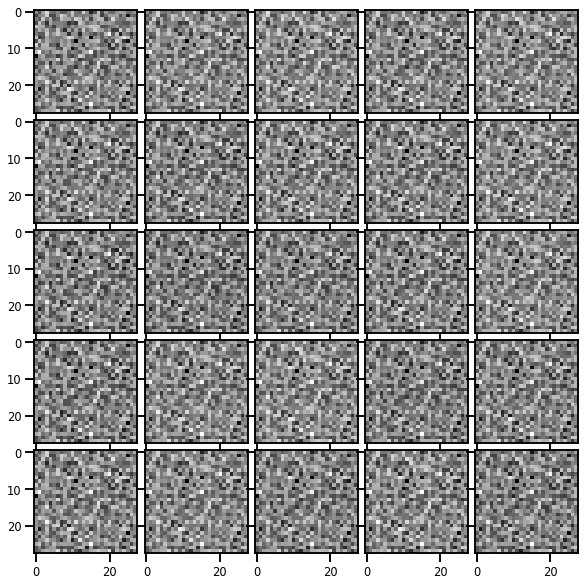

In [56]:
# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_g, image_shape)

wandb.log({"initial_latent_images": wandb.Image(plt)})

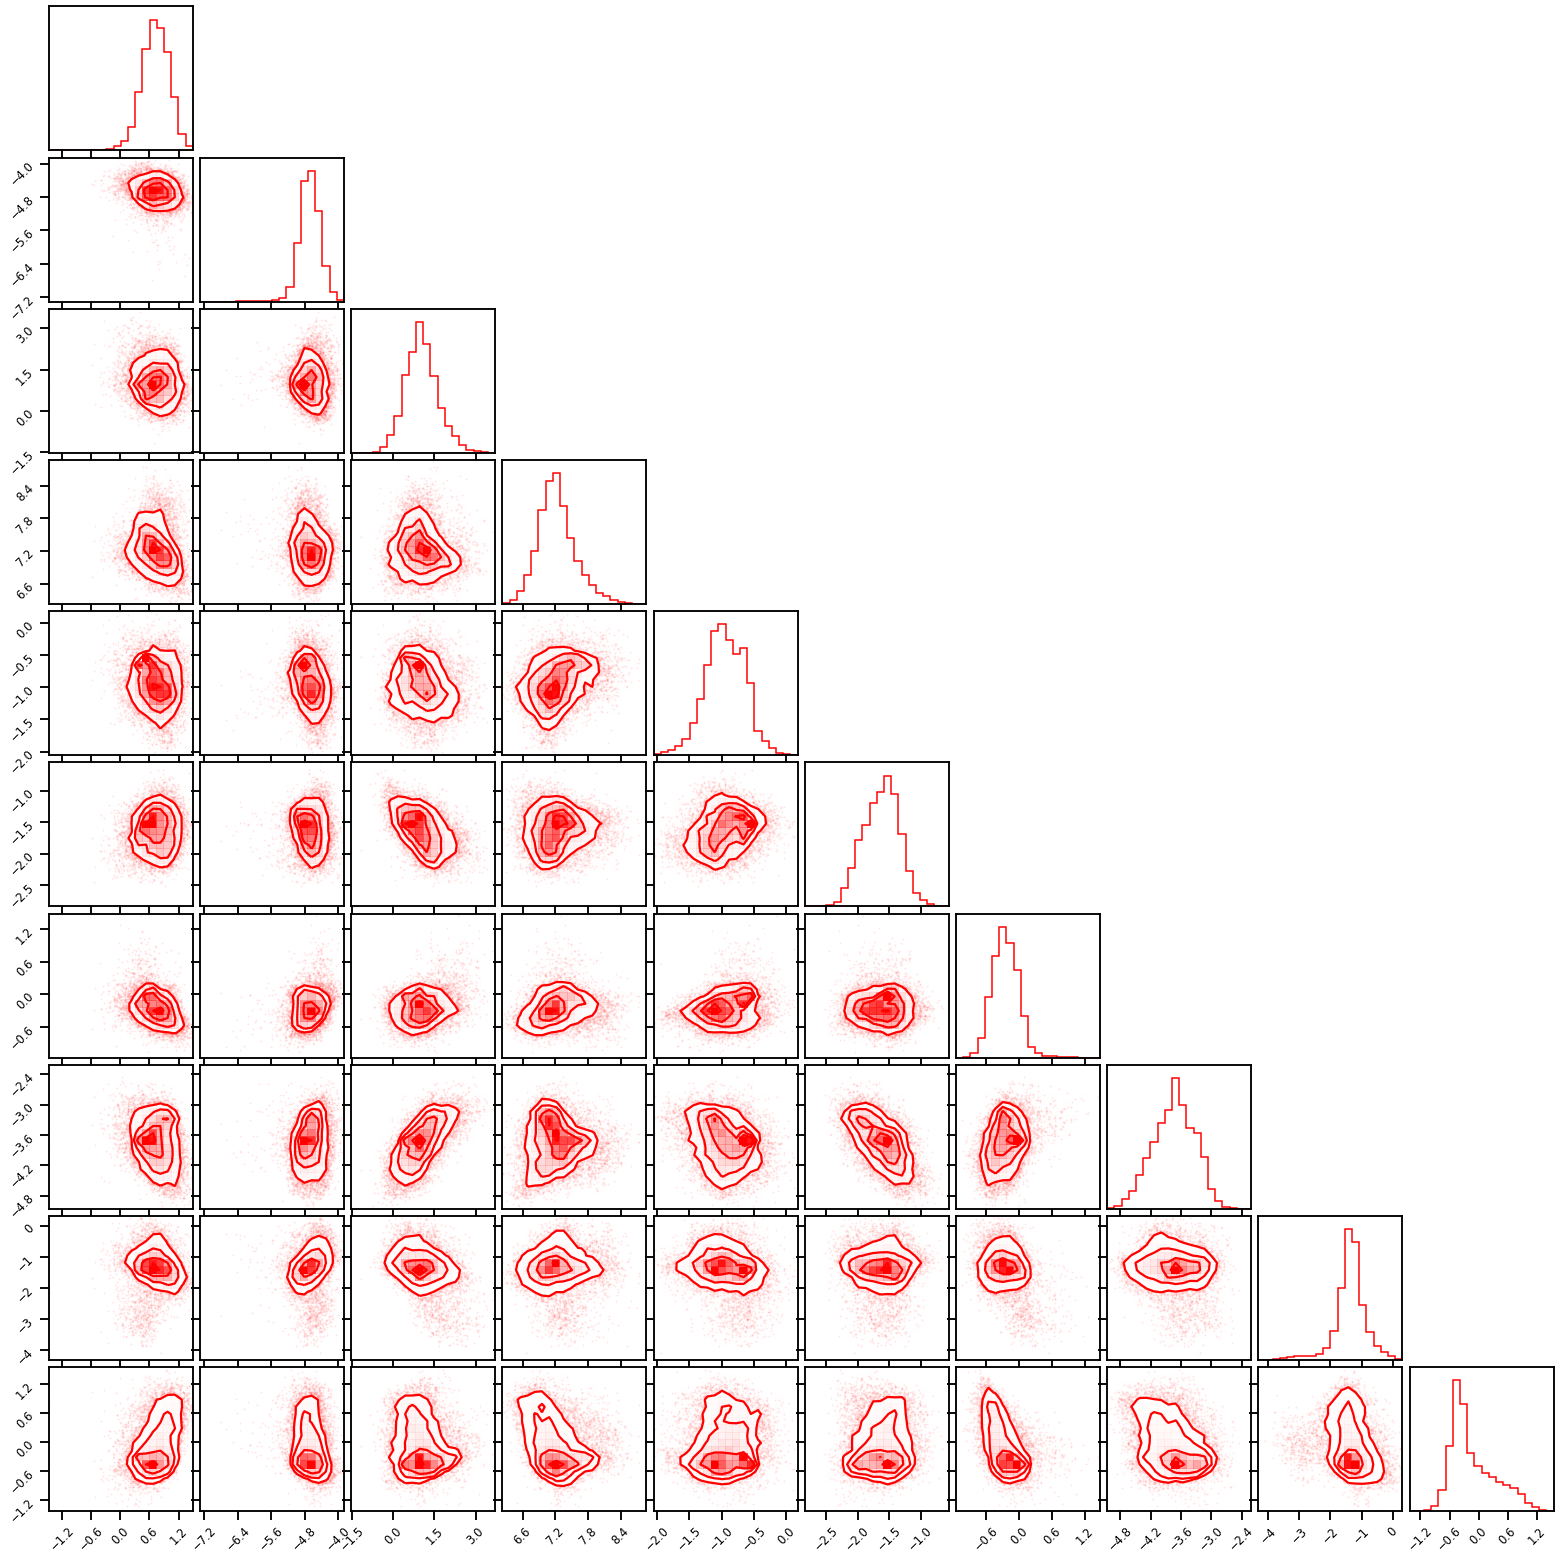

In [57]:
fig = corner.corner(np.array(X_g[:, :10]), color="red")

### Initial Score

In [58]:
%%time


gf_model.score(demo_data_prepped[:50])

CPU times: user 9.56 s, sys: 156 ms, total: 9.71 s
Wall time: 9.95 s


DeviceArray(8341.639, dtype=float32)

#### Inverse

In [59]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_g)

CPU times: user 45.5 s, sys: 4.72 s, total: 50.2 s
Wall time: 21.6 s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f162466edf0>)

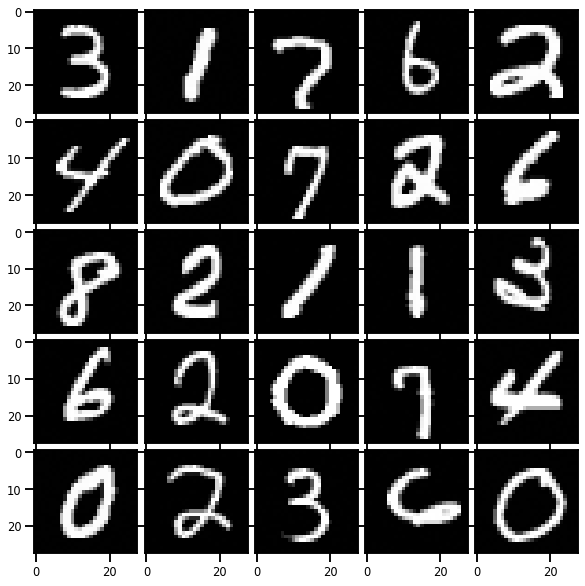

In [60]:
# plot demo images
plot_image_grid(X_demo_approx, image_shape)

### Loss Function

We're going to minimize the log probability

In [61]:
from rbig_jax.training.parametric import init_optimizer

n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam",
    n_epochs=n_epochs,
    lr=2e-4,
    cosine_decay_steps=n_epochs,
    warmup=None,
    gradient_clip=15.0,
    alpha=1e-1,
)

In [62]:
from rbig_jax.training.parametric import GaussFlowTrainer

# initial flow trainer
nf_trainer = GaussFlowTrainer(
    gf_model, optimizer, n_epochs=n_epochs, prepare_data_fn=prepare_data
)

In [63]:
# number of epochs
# epochs = 250
eval_frequency = 50
# split the keys into a unique subset
train_rng = jax.random.split(rng, num=n_epochs)

# create an iterator
train_rng = iter(train_rng)

batch_size = 64

try:
    del init_ds
except:
    pass
train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, 1_000)

In [64]:
from rbig_jax.losses import nll_2_bpd

img_shape = X_init.shape[1:]
img_shape

(784,)

In [65]:
# %%wandb

import tqdm

# metrics = {
#     "train_step": list(),
#     "train_loss": list(),
#     "valid_step": list(),
#     "valid_loss": list(),
# }


# eval_loss = 0.0
# with tqdm.trange(epochs) as pbar:
#     for step in pbar:
#         gf_model, opt_state, loss = update(gf_model, next(train_rng), opt_state, next(train_ds))

eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = nf_trainer.train_step(next(train_ds), rng=next(train_rng))
        train_loss = output.loss
        train_loss = nll_2_bpd(train_loss, img_shape)
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = nf_trainer.validation_step(next(valid_ds))
            eval_loss = output.loss
            eval_loss = nll_2_bpd(eval_loss, X_init.shape[1:])
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

gf_model = output.model

Train Loss: -3.8922 | Valid Loss: -3.1140: 100%|██████████| 5000/5000 [31:43<00:00,  2.63it/s]  


In [40]:
gf_model = output.model

## Results

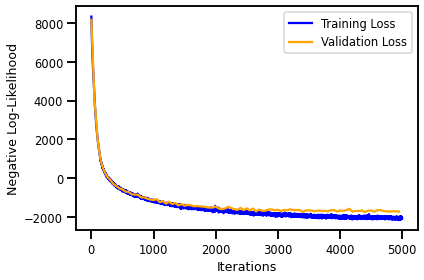

In [22]:
fig, ax = plt.subplots()
ax.plot(
    nf_trainer.train_epoch, nf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    nf_trainer.valid_epoch,
    nf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

CPU times: user 26.4 s, sys: 3.34 s, total: 29.7 s
Wall time: 9.98 s


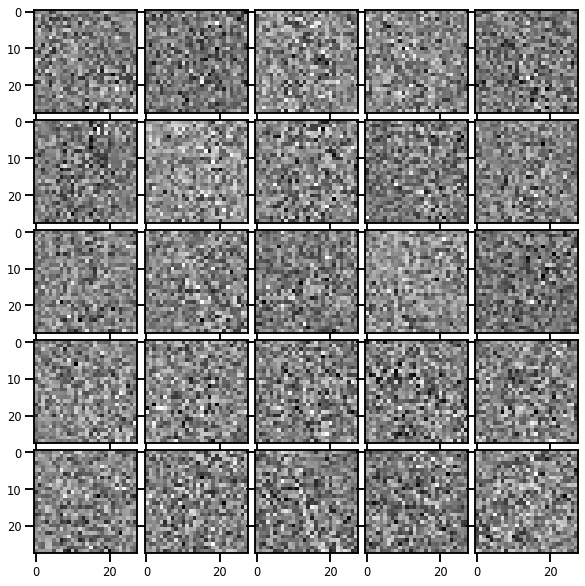

In [23]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(X_init)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"final_latent_images": wandb.Image(plt)})

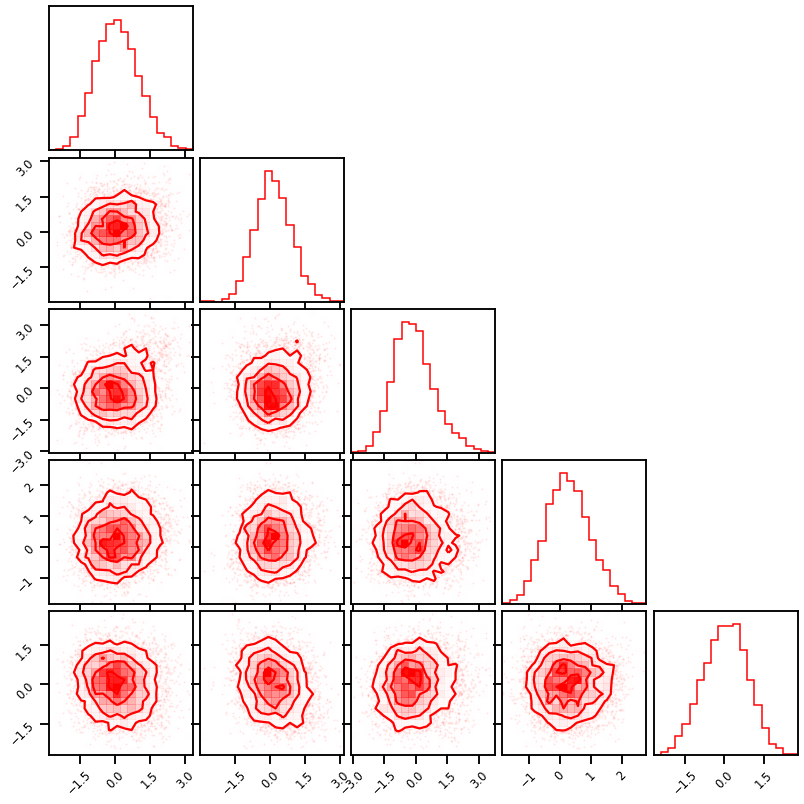

In [24]:
fig = corner.corner(np.array(X_demo_g[:, :5]), color="red")
wandb.log({"final_latent_histogram": wandb.Image(plt)})

CPU times: user 27.2 s, sys: 3.04 s, total: 30.3 s
Wall time: 9.82 s


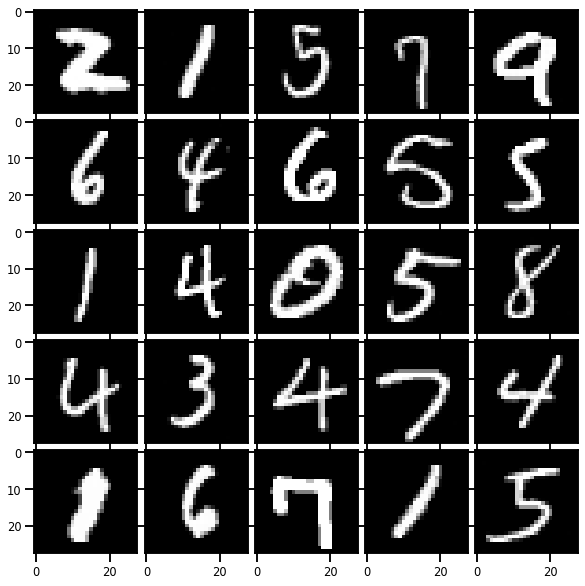

In [25]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_approx, image_shape)
# plot image grid

wandb.log({"inverse_transform_images": wandb.Image(plt)})

In [26]:
X_g_samples.shape

NameError: name 'X_g_samples' is not defined

### Sampling

CPU times: user 53.5 s, sys: 7.44 s, total: 1min
Wall time: 18.6 s


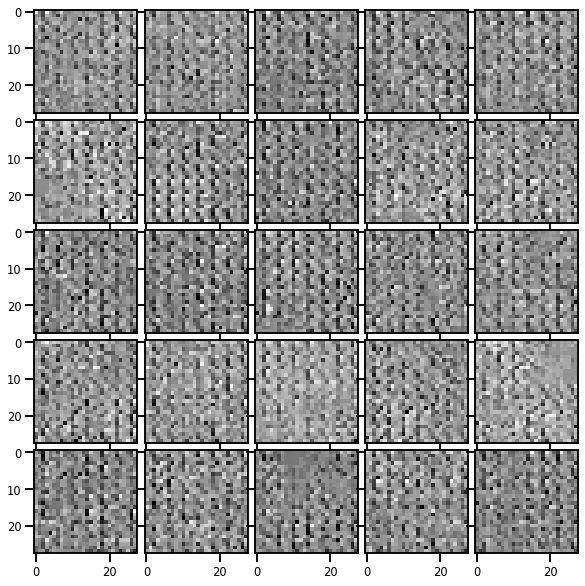

In [27]:
%%time

# X_g_samples = jax.random.randn((5_000, 784))
n_gen_samples = 10_000
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

# plot
fig, ax = plot_image_grid(X_samples, image_shape)

wandb.log({"generated_samples_images": wandb.Image(plt)})

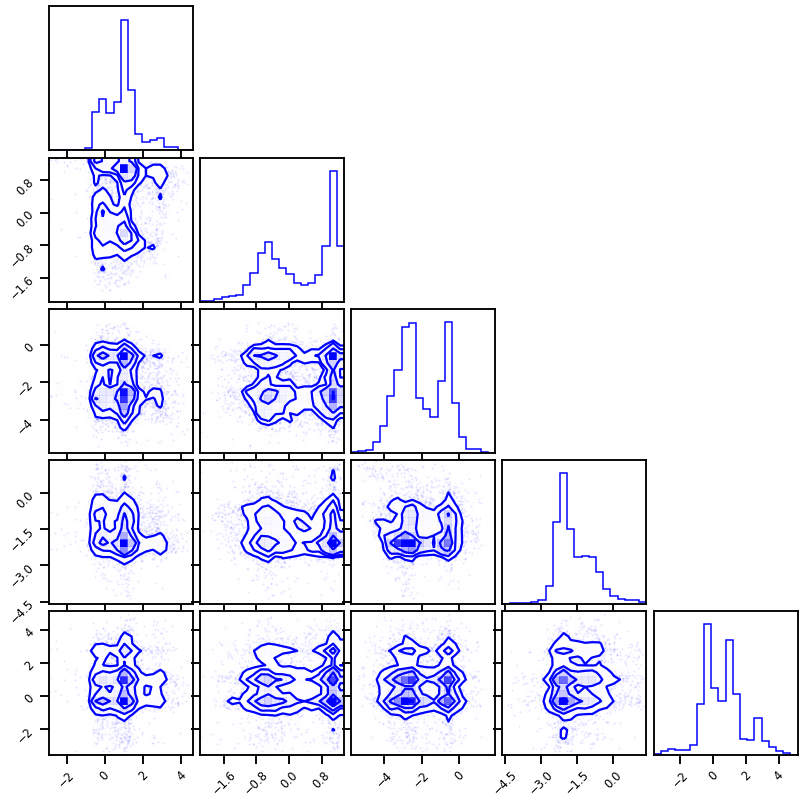

In [53]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

wandb.log({"generated_samples_histogram": wandb.Image(plt)})

In [57]:

X_g = X_init.copy()[:50]

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g[:,:5], color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
        break
        
    
    

Error in callback <function _WandbInit._resume_backend at 0x7f0d6061f790> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AssertionError: I don't believe that you want more dimensions than samples!

Error in callback <function _WandbInit._pause_backend at 0x7f0d6061f310> (for post_run_cell):


Exception: The wandb backend process has shutdown

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 198, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 735, in communicate_stop_status
    resp = self._communicate(req, timeout=timeout, local=True)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 537, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/wandb/sd

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [101]:
import joblib

#### Save Model

In [102]:
model_save_name = os.path.join(wandb.run.dir, "gf_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

['gf_model_mnist.pickle']

#### Load Model

In [103]:
gf_model_ = joblib.load(model_save_name)